### GIZ Initial Data Exploration
#### author: Emily Robitschek

Purpose: Before we build any model, we need to be able to take a look at the documents we have.

Some resources: 

#### papers mentioned in project proposal: 
https://medium.com/fiscalnoteworthy/citing-your-sources-79062248f468
https://www2.deloitte.com/us/en/insights/focus/cognitive-technologies/natural-language-processing-examples-in-government-data.html
https://documents1.worldbank.org/curated/en/634591516387264234/pdf/WPS8310.pdf

#### NLP related links: 
- https://spacy.io/usage/spacy-101
- https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
- https://arunm8489.medium.com/getting-started-with-natural-language-processing-6e593e349675
- https://towardsdatascience.com/natural-language-processing-pipeline-decoded-f97a4da5dbb7

### Import libraries

In [1]:
import os
import glob
import time
import json
import codecs
import re

import scipy
import numpy as np
import pandas as pd

#set up packages for processing data types and for NLP analysis
from collections import OrderedDict, Counter
import contractions
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm') #or the multi-language one: spacy.load('xx_ent_wiki_sm')

#graphing/visualization packages: 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

### Define helper functions for preprocessing

In [2]:
from datahelper import *
from nlppreprocess import *
from nlpanalysis import *

### Import data: Keywords from NDCs

In [128]:
#keywords (just for testing purposes - from the policy proposal from GIZ)
policy = ["policy", "integrate", "implement", "committee", "consultation"]
food = ["nutritions", "diets", "farm", "agriculture", "ecology"]
ndc_national_adaption_plan = ["nap", "sector plan", "nccrp", "vulnerable sector", 
                              "geographic vulnerability"]
ndc_climate_change = ["adaption", "program", "projects", "resilience", "institution",
                      "capacity", "response", "budget", "reprioritisation", "development", 
                      "planner", "regulator", "practitioners", "geographical", 
                      "circumstances", "land", "scheme", "authorisation", "system", 
                      "spluma"]
ndc_early_warning = ["system", "vulnerability", "needs", "assessment", "network", "weather",
   "earth", "observation", "academic", "community"]

#keywords from json file
json_keywords_SA_file = '../ndc_keywords/ndc_south_africa.json'
keywords_SA_dict = None
with open(json_keywords_SA_file, 'r') as f: 
    keywords_SA_dict = json.load(f)
keywords_SA_dict

ndc_dict = make_filtered_tokens_from_ndc(keywords_SA_dict)

In [129]:
### THIS IS A PLACEHOLDER ###
#get words directly from NDCs (eventually want to get words from the NDC itself and group them by topics.)
#
#
#
ndc_dict

{'national adaption plan': ['national',
  'adaption',
  'plan',
  'nap',
  'sector',
  'nccrp',
  'vulnerable',
  'geographic',
  'vulnerability'],
 'climate change': ['climate',
  'change',
  'adaption',
  'program',
  'project',
  'resilience',
  'institutional',
  'capacity',
  'response',
  'budget',
  'reprioritisation',
  'development',
  'planner',
  'regulator',
  'practitioner',
  'geographical',
  'circumstance',
  'land',
  'use',
  'scheme',
  'authorisation',
  'system',
  'spatial',
  'management',
  'act',
  'spluma',
  'paris',
  'agreement'],
 'early warning': ['early',
  'warning',
  'system',
  'vulnerability',
  'need',
  'assessment',
  'network',
  'weather',
  'service',
  'earth',
  'observation',
  'academic',
  'community',
  'warn']}

In [5]:
#extra functions
def make_ndc_keyword_tidy_df_from_dict(key, col_group_name, ndc_dict):
    ndc_df = pd.DataFrame({'keyword': ndc_dict[key], 
                       col_group_name: key})
    return ndc_df

def stack_tidy_ndc_dfs(col_group_name, ndc_dict):
    ndc_df = pd.DataFrame()
    for key in ndc_dict.keys():
        ndc_df_add = make_ndc_keyword_tidy_df_from_dict(key, col_group_name, ndc_dict)
        ndc_df = pd.concat([ndc_df, ndc_df_add], axis=0)
    return ndc_df

# lets apply: 
col_group_name = 'NDC'
ndc_df = stack_tidy_ndc_dfs(col_group_name, ndc_dict)
ndc_df.head()


def make_ndc_idx_tidy_df(ndc_dict, topic_name, tokens):
    ndc_idx_df = pd.DataFrame()
    for key in ndc_dict.keys(): 
        ndc_idx_df_to_add = pd.DataFrame({topic_name: key,
                                          #('%s word_index'%(key)): [token.idx for token in tokens if token.text in ndc_dict[key]],
                                          'word_index': [token.idx for token in tokens if token.text in ndc_dict[key]]})
        ndc_idx_df = pd.concat([ndc_idx_df, ndc_idx_df_to_add], axis=0)
    return ndc_idx_df

def filter_idx_for_overlap(idxs, min_dist):
    distance_btwn_idxs = [(idxs[i+1]-idxs[i]) for i in range(0, len(idxs)-1)]
    print(distance_btwn_idxs[:20])
    filtered_idxs = []
    for index, distance in enumerate(distance_btwn_idxs):
        if (distance >= min_dist):
            filtered_idxs.append(idxs[index])
        else:
            pass
    print("The number of times the idx words were found was: ", len(idxs), "\n", 
          "The number of idx words seperated by at least the min_distance was : ", len(filtered_idxs))
    return filtered_idxs
    
def make_window_text(tokens, max_length):
    filtered_for_length = [token.text.lower() for token in tokens if len(token) < max_length]
    text_for_windows = ' '.join(filtered_for_length)
    window_tokens = nlp(text_for_windows)
    return window_tokens

def return_window(ndc_word_index, tokens, size=100):
    lower_limit = ndc_word_index - size
    upper_limit = ndc_word_index + size
    token_idxs = [token.idx for token in tokens]
    window_token_list = []
    #print('The window is ', lower_limit, upper_limit)
    for index, idx in enumerate(token_idxs):
        if (idx >= lower_limit) and (idx <= upper_limit):
            window_token_list.append(tokens[index])
        else:
            pass
    text_for_windows = ' '.join(list(token.text for token in window_token_list))
    window_tokens = nlp(text_for_windows)
    return lower_limit, upper_limit, window_tokens

def find_patterns_df(pattern_list, text, topic_name):
    pattern_locations = []
    pattern_num = []
    for pattern in pattern_list:
        #print(pattern)
        re.findall(pattern, text, flags=0)
        #pattern_locations = [(m.start(0), m.end(0)) for m in re.finditer(pattern, text)] #if want start and end
        locations = [m.start(0) for m in re.finditer(pattern, text)]
        pattern_locations.append(locations)
        pattern_num.append(int(len(locations)))
    #print(pattern_locations)
        #if len(pattern_locations) > 0: 
        #    print(pattern, len(pattern_locations), pattern_locations)
    return pd.DataFrame({'sdg_topic': topic_name,
                         'sdg_keywords': pattern_list,
                         'sdg_keywords_num': pattern_num,
                         'sdg_keyword_locations': pattern_locations})

def make_sdg_df(sdg_list, sdg_ontology, text):
    df_sdg = pd.DataFrame()
    for sdg in list(sdg_list):
        sdg_keywords = list(sdg_ontology[sdg_ontology['clasification']==sdg]['keyword'])
        #print(sdg)
        df_sdg_to_add = find_patterns_df(sdg_keywords, text, topic_name=sdg)
        df_sdg = pd.concat([df_sdg, df_sdg_to_add])
    return df_sdg

### SDG and other topic keywords

In [6]:
sdg_ontology = pd.read_csv('../additional_resources/Ontology_final_modified.csv', sep=';')#, #skiprows=0)

sdg_list = ['SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9', 
            'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17', 
            "mention_money"]

sdg_ontology.head(20)

,keyword,clasification
0,"""bop"" countries",SDG1
1,absolute poverty,SDG1
2,bellagio principles,SDG1
3,child nutritional status,SDG1
4,counting marginalised children,SDG1
5,dimensions of inequality,SDG1
6,diseases of poverty,SDG1
7,economic marginalisation,SDG1
8,education poverty,SDG1
9,educational poverty,SDG1


### Import data: Policy-related documents to analyze

In [7]:
#here is the general folder with the different types of policy documents
policy_doc_folder = '../test_resources'
policy_doc_folder = '../../policy_tracking_docs'
#get df of docs
policy_doc_df = read_docs_to_df(policy_doc_folder)
print(len(policy_doc_df))
policy_doc_df.head()

162


,policy_doc_paths,policy_doc_name_clean
policy_doc_names,,
210401_Mid Way Economic Reforms EDITORIAL EN.pdf_ocr.txt,../../policy_tracking_docs/Ethiopia/TXT/Websit...,210401_Mid Way Economic Reforms EDITORIAL EN.p...
190909_Homegrown Economic Reforms Speech.txt,../../policy_tracking_docs/Ethiopia/TXT/Websit...,190909_Homegrown Economic Reforms Speech
210401_Fuel Sector Article EN.pdf_ocr.txt,../../policy_tracking_docs/Ethiopia/TXT/Websit...,210401_Fuel Sector Article EN.pdf_ocr
190429_Belt and Road Forum Leaders Roundtable Speech_ocr.txt,../../policy_tracking_docs/Ethiopia/TXT/Websit...,190429_Belt and Road Forum Leaders Roundtable ...
210401_Fuel Sector Article EN.txt,../../policy_tracking_docs/Ethiopia/TXT/Websit...,210401_Fuel Sector Article EN


### Preprocess data

In [182]:
##lets take a look at the document from South Africa used in the example in the proposal first:
doc_name = '2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt'
doc_path = policy_doc_df.loc[doc_name]['policy_doc_paths']

#can also simply specify the first or whichever document in the list by order: 
#(this will be helpful for future versions that involve more interrating over different documents)
i=53
#doc_name = policy_doc_df.iloc[i]['policy_doc_name_clean']
#doc_path = policy_doc_df.iloc[i]['policy_doc_paths']

def run_nlp_pipeline(doc_name, doc_path, ndc_dict, max_word_length):
    print(doc_name, doc_path)
    tokens, token_list, sentences = preprocess_doc(doc_path)
    filtered_tokens = filter_modify_tokens(tokens)
    print('These are some of the filtered tokens: ', filtered_tokens[0:10])
    #words = [token.text for token in filtered_tokens]
    #word_freq = Counter(words)
    #for key in ndc_dict.keys():
    #    topic_frequencies =  calculate_topic_frequency_subset(word_freq, ndc_dict, str(key))
    #ndc_climate_idxs = [token.idx for token in tokens if token.text in ndc_dict['climate change']]
    document_text = ' '.join([token.text for token in tokens if len(token.text)<=max_word_length])
    topic_name='NDC'
    ndc_idx_df = make_ndc_idx_tidy_df(ndc_dict, topic_name, tokens)
    ndc_idx_df.index = ndc_idx_df.NDC.copy()
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)
    doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    doc_summary_sdg_df = doc_summary_sdg.to_frame().rename(columns={"sdg_keywords_num": doc_name})
    return tokens, token_list, filtered_tokens, ndc_idx_df, doc_summary_sdg, doc_summary_sdg_df #topic_frequencies, sentences


max_word_length=25
summary_sdg_df_doc = pd.DataFrame()
count = 1
for i in range(0, len(policy_doc_df[:3])):
    doc_name = policy_doc_df.iloc[i]['policy_doc_name_clean']
    doc_path = policy_doc_df.iloc[i]['policy_doc_paths']
    tokens, token_list, filtered_tokens, ndc_idx_df, doc_summary_sdg, doc_summary_sdg_df = run_nlp_pipeline(doc_name, doc_path, ndc_dict, max_word_length)   
    print(ndc_idx_df.NDC.value_counts())
    if count == 1: 
        summary_sdg_df_doc = doc_summary_sdg_df
        total = doc_summary_sdg_df[doc_name].sum()
        print(doc_name, len(filtered_tokens), total)
    else: 
        summary_sdg_df_doc_for_merge = doc_summary_sdg_df
        total = summary_sdg_df_doc_for_merge[doc_name].sum()
        print(doc_name, len(filtered_tokens), total)
        summary_sdg_df_doc = summary_sdg_df_doc.merge(summary_sdg_df_doc_for_merge, left_index=True, right_index=True)
    count += 1
    #print(ndc_idx_df.head())
summary_sdg_df_doc.head() 

210401_Mid Way Economic Reforms EDITORIAL EN.pdf_ocr ../../policy_tracking_docs/Ethiopia/TXT/Website/Other/210401_Mid Way Economic Reforms EDITORIAL EN.pdf_ocr.txt
These are some of the filtered tokens:  analas rgae aoneasl ctaman pmpal llatc khdt wt e federal
national adaption plan    29
climate change            11
early warning              2
Name: NDC, dtype: int64
210401_Mid Way Economic Reforms EDITORIAL EN.pdf_ocr 967 145
190909_Homegrown Economic Reforms Speech ../../policy_tracking_docs/Ethiopia/TXT/Website/Other/190909_Homegrown Economic Reforms Speech.txt
These are some of the filtered tokens:  ethiopia new horizon hope distinguished member diplomatic community distinguished development
climate change            9
national adaption plan    4
early warning             1
Name: NDC, dtype: int64
190909_Homegrown Economic Reforms Speech 421 58
210401_Fuel Sector Article EN.pdf_ocr ../../policy_tracking_docs/Ethiopia/TXT/Website/Other/210401_Fuel Sector Article EN.pdf_ocr.txt
The

,210401_Mid Way Economic Reforms EDITORIAL EN.pdf_ocr,190909_Homegrown Economic Reforms Speech,210401_Fuel Sector Article EN.pdf_ocr
sdg_topic,,,
SDG1,0,0,0
SDG10,3,7,2
SDG11,4,6,2
SDG12,0,0,1
SDG13,2,1,0


In [11]:
summary_sdg_df_doc

,210401_Mid Way Economic Reforms EDITORIAL EN.pdf_ocr,190909_Homegrown Economic Reforms Speech,210401_Fuel Sector Article EN.pdf_ocr,190429_Belt and Road Forum Leaders Roundtable Speech_ocr,210401_Fuel Sector Article EN,190429_Belt and Road Forum Leaders Roundtable Speech,190909_Homegrown Economic Reforms Speech.pdf_ocr,190429_Belt and Road Forum Opening Speech.pdf_ocr,200514_COVID 19 Economic Response Measures .pdf_ocr,200514_COVID 19 Economic Response Measures,...,environmentquarterly_july_september2017.pdf_ocr,environmentquarterly_july_september2018,dea-annual-report-2019-20.pdf_ocr,dea-annual-report-2015-16,dea-annual-report-2018-19,dea-annual-report-2014-15.pdf_ocr,dea-annual-report-2014-15,dea-annual-report-2015-16.pdf_ocr,dea-annual-report-2018-19.pdf_ocr,dea-annual-report-2019-20
sdg_topic,,,,,,,,,,,,,,,,,,,,,
SDG1,0,0,0,0,0,0,0,1,0,0,...,6,20,2,1,2,3,3,1,2,2
SDG10,3,7,2,2,2,2,7,4,0,0,...,40,31,26,78,74,78,84,74,74,62
SDG11,4,6,2,1,2,1,6,1,5,5,...,128,145,63,115,147,75,87,93,147,170
SDG12,0,0,1,0,1,0,0,0,1,1,...,74,55,59,115,164,91,104,101,152,118
SDG13,2,1,0,0,0,0,1,0,1,1,...,26,79,43,89,108,93,97,78,105,73
SDG14,0,0,0,0,0,0,0,0,0,0,...,27,52,36,57,88,64,64,56,88,52
SDG15,3,4,0,1,0,1,4,0,0,0,...,179,125,205,281,336,317,326,281,331,312
SDG16,37,5,17,3,18,3,5,9,14,15,...,160,147,151,267,301,261,296,242,299,307
SDG17,8,2,1,0,1,0,2,1,0,0,...,63,112,69,119,117,103,117,107,116,121


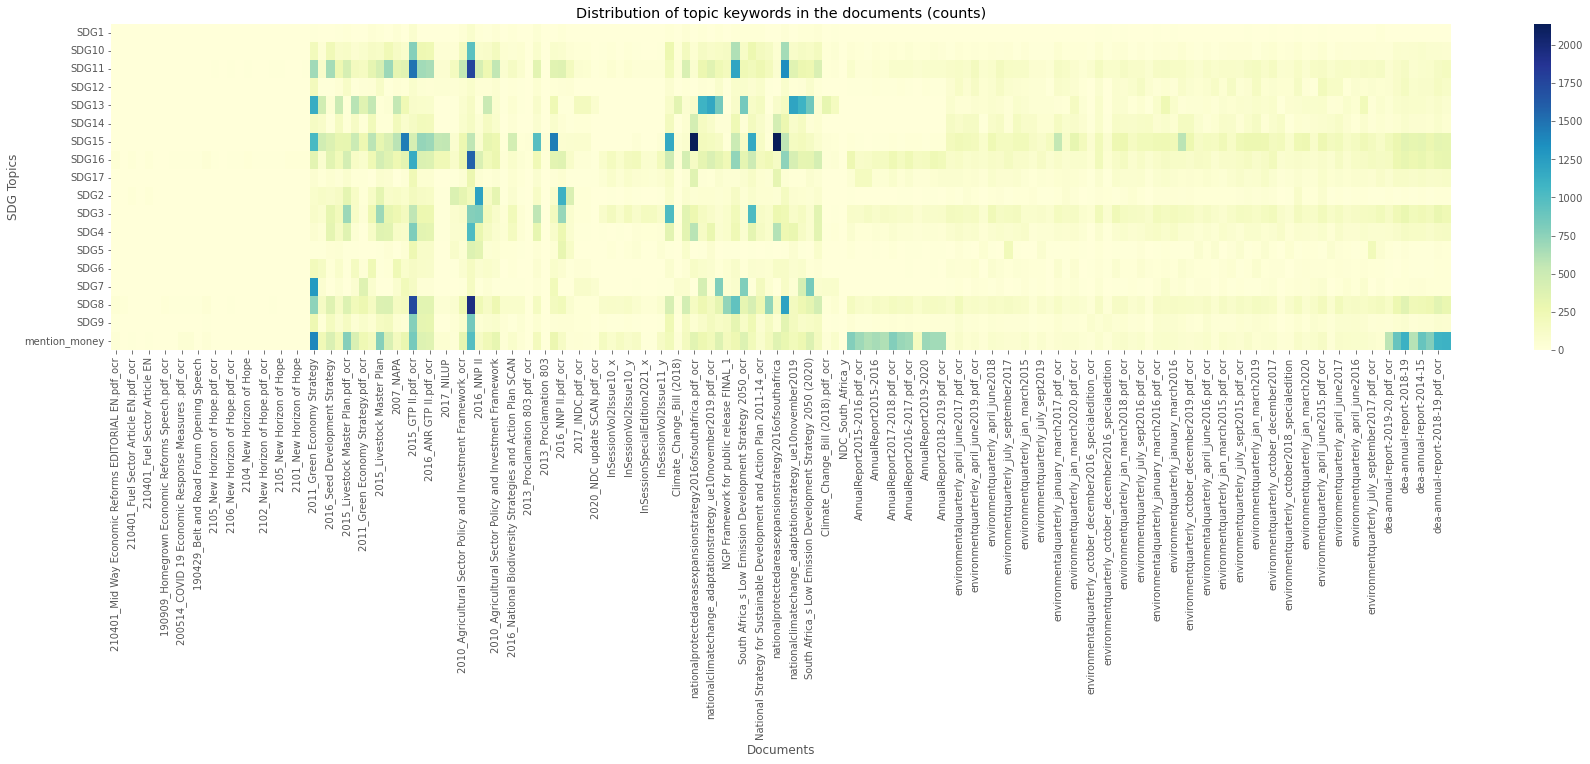

In [12]:
#make heatmap of plot above
plot_folder = '../../outputs/heatmaps/'
plt.figure(figsize=(30, 6)) #16, 6
ax = sns.heatmap(summary_sdg_df_doc,
                 #annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("Documents")
plt.ylabel("SDG Topics")
title = ("Distribution of topic keywords in the documents (counts)")
plt.title(title)
file_name=(title + (' all docs SA v1.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

In [121]:
#summary_sdg_df_doc.sum(axis=0)
#print(summary_sdg_df_doc.div(summary_sdg_df_doc.sum(axis=0), axis=1))
normed_by_col_sum = summary_sdg_df_doc.div(summary_sdg_df_doc.sum(axis=0), axis=1).round(3)
normed_by_col_sum.head()
#normed_by_col_sum.round(2)

,210401_Mid Way Economic Reforms EDITORIAL EN.pdf_ocr,190909_Homegrown Economic Reforms Speech,210401_Fuel Sector Article EN.pdf_ocr,190429_Belt and Road Forum Leaders Roundtable Speech_ocr,210401_Fuel Sector Article EN,190429_Belt and Road Forum Leaders Roundtable Speech,190909_Homegrown Economic Reforms Speech.pdf_ocr,190429_Belt and Road Forum Opening Speech.pdf_ocr,200514_COVID 19 Economic Response Measures .pdf_ocr,200514_COVID 19 Economic Response Measures,...,environmentquarterly_july_september2017.pdf_ocr,environmentquarterly_july_september2018,dea-annual-report-2019-20.pdf_ocr,dea-annual-report-2015-16,dea-annual-report-2018-19,dea-annual-report-2014-15.pdf_ocr,dea-annual-report-2014-15,dea-annual-report-2015-16.pdf_ocr,dea-annual-report-2018-19.pdf_ocr,dea-annual-report-2019-20
sdg_topic,,,,,,,,,,,,,,,,,,,,,
SDG1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.032,0.000,0.000,...,0.004,0.014,0.001,0.000,0.001,0.001,0.001,0.000,0.001,0.001
SDG10,0.021,0.121,0.025,0.071,0.025,0.071,0.121,0.129,0.000,0.000,...,0.028,0.022,0.016,0.029,0.022,0.033,0.030,0.030,0.022,0.020
SDG11,0.028,0.103,0.025,0.036,0.025,0.036,0.103,0.032,0.057,0.057,...,0.090,0.101,0.038,0.042,0.043,0.032,0.031,0.037,0.044,0.054
SDG12,0.000,0.000,0.013,0.000,0.012,0.000,0.000,0.000,0.011,0.011,...,0.052,0.038,0.036,0.042,0.048,0.039,0.037,0.041,0.046,0.037
SDG13,0.014,0.017,0.000,0.000,0.000,0.000,0.017,0.000,0.011,0.011,...,0.018,0.055,0.026,0.033,0.032,0.040,0.034,0.031,0.031,0.023


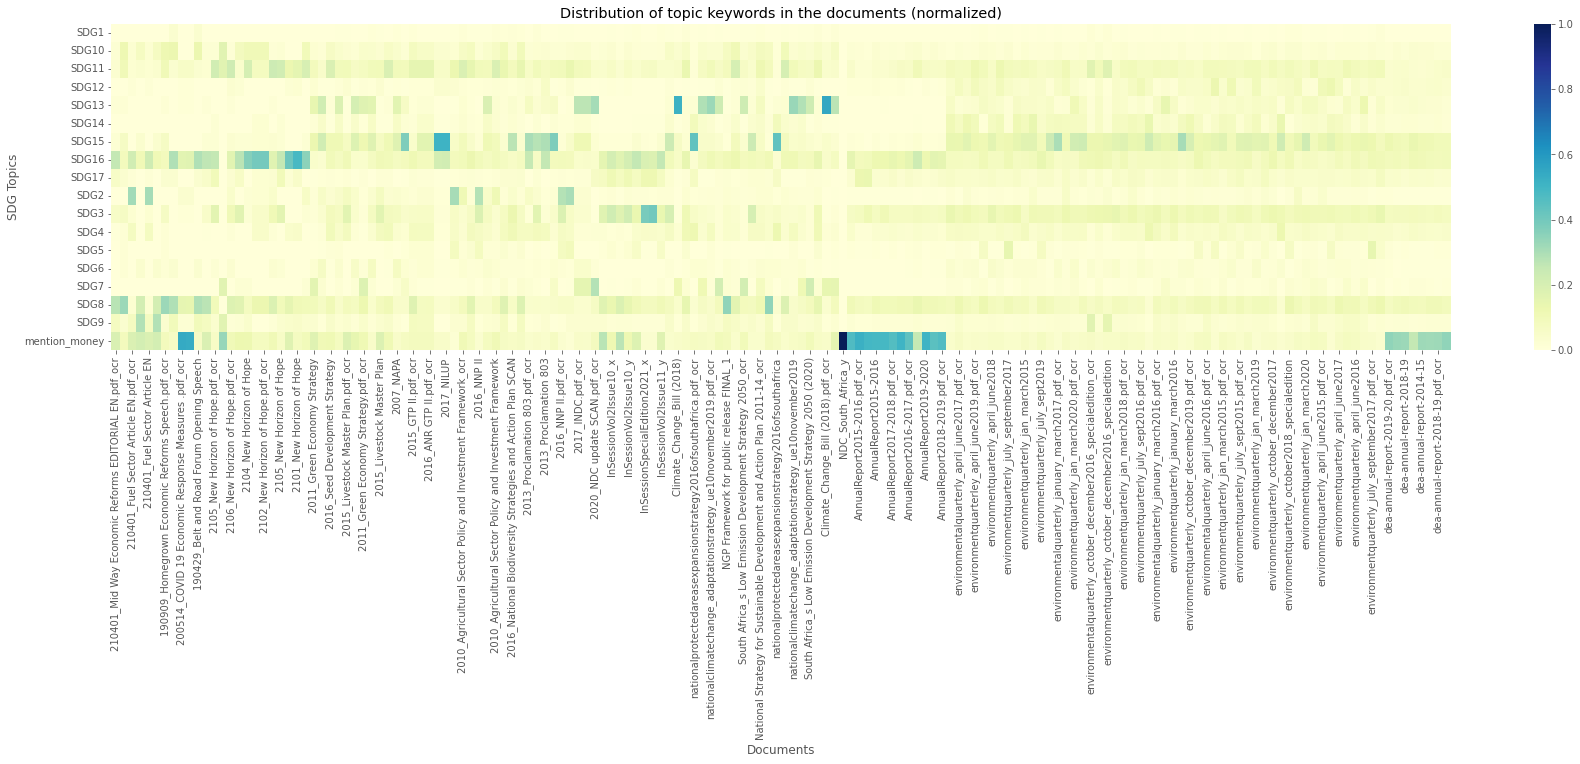

In [122]:
plt.figure(figsize=(30, 6)) #16, 6
ax = sns.heatmap(normed_by_col_sum,
                 #annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("Documents")
plt.ylabel("SDG Topics")
title = ("Distribution of topic keywords in the documents (normalized)")
plt.title(title)
file_name=(title + (' all docs SA v1.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

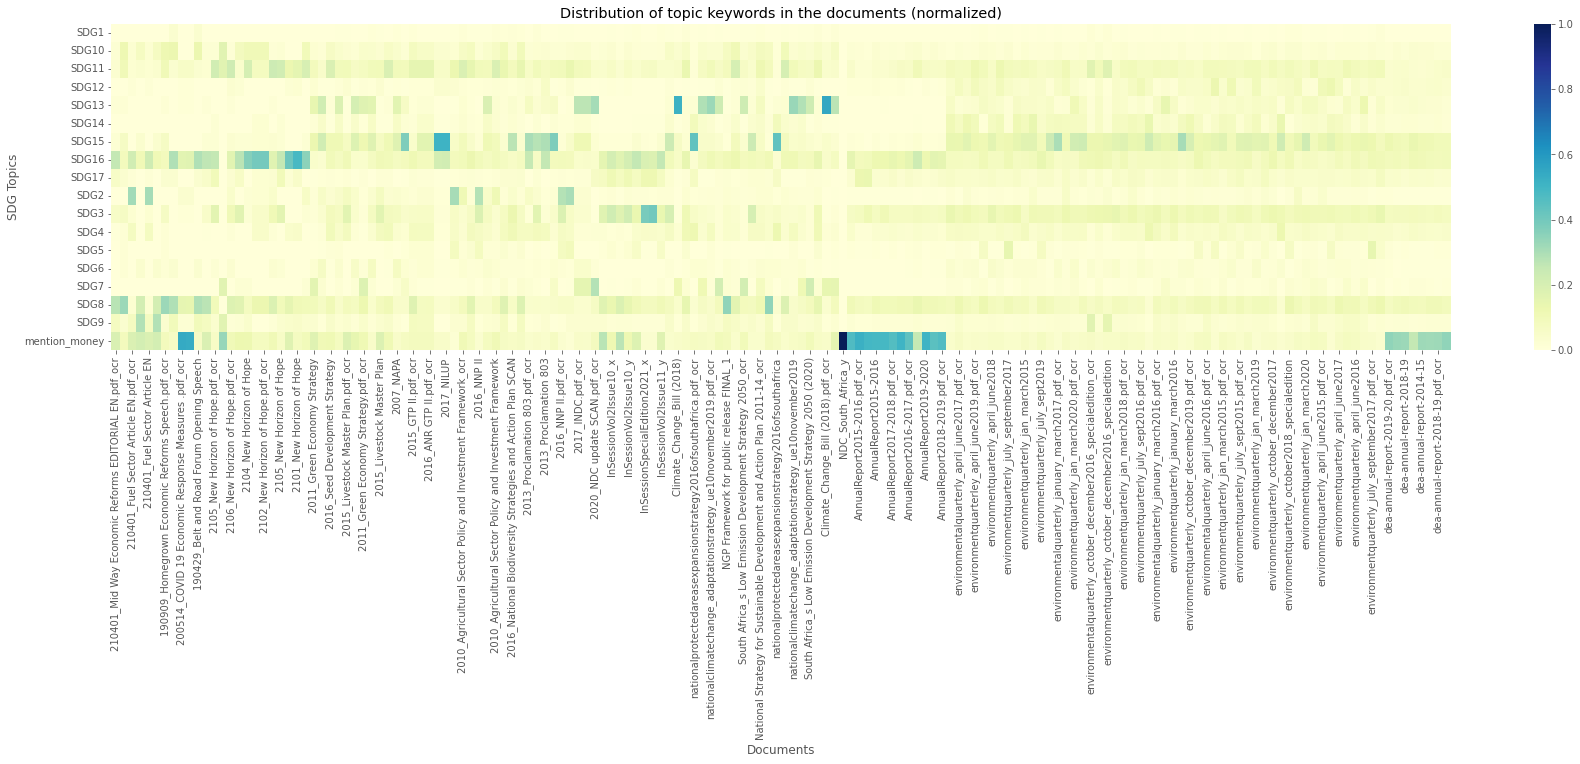

In [125]:
plt.figure(figsize=(30, 6))
ax = sns.heatmap(normed_by_col_sum,
                 #annot=True, #fmt="f", 
                 cmap="YlGnBu")
plt.xlabel("Documents")
plt.ylabel("SDG Topics")
title = ("Distribution of topic keywords in the documents (normalized)")
plt.title(title)
file_name=(title + (' all docs SA v1.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

<Figure size 720x2160 with 0 Axes>

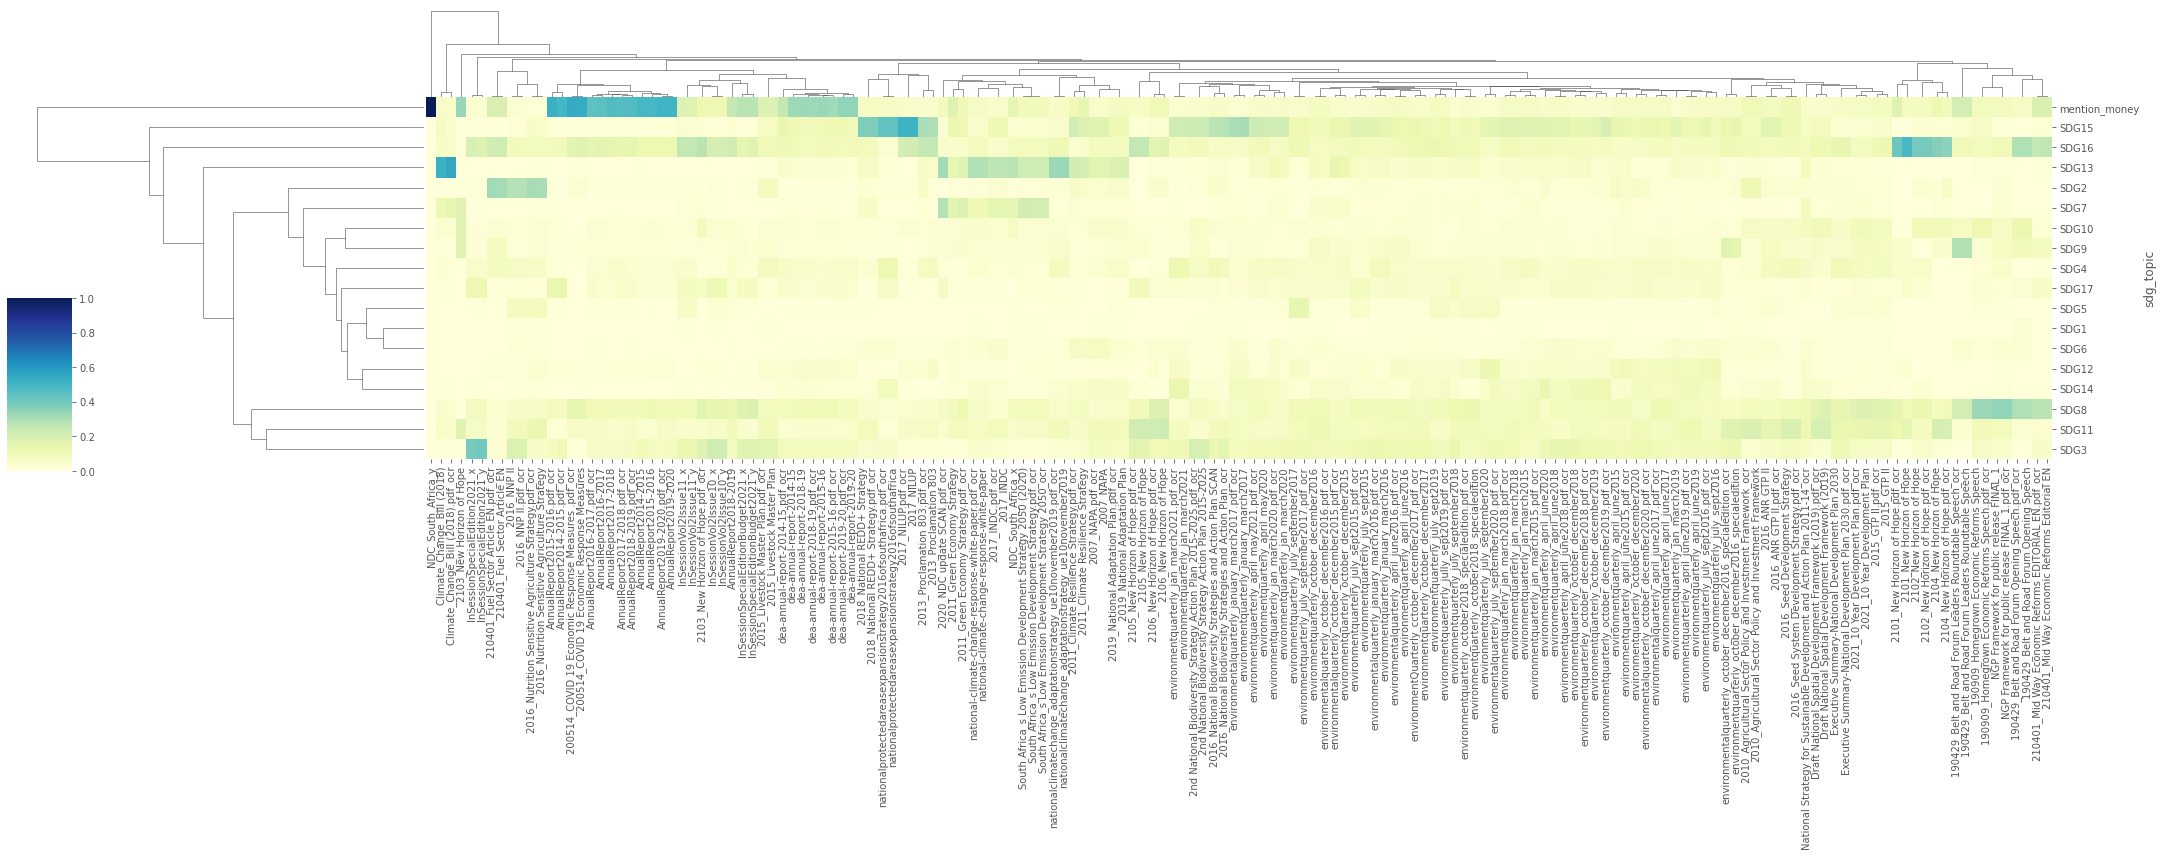

In [143]:
plt.figure(figsize=(10, 30))
ax = sns.clustermap(normed_by_col_sum,
                 #annot=True,
                 cbar_pos=(0, .45, .03, .2),
                 cmap="YlGnBu", 
                 xticklabels=1, 
                 figsize=(30, 12))
#plt.xlabel("Documents")
#plt.ylabel("SDG Topics")
title = ("Distribution of topic keywords in the documents (normalized)")
#plt.title(title)
file_name=(title + (' clustermap all docs SA v2.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
ndc_idx_df.NDC.value_counts()#head()

In [29]:
#look at SDGs across document/at document level
max_length=25
document_text = ' '.join([token.text for token in tokens if len(token.text)<=max_length])

df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)
doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
doc_summary_sdg_df = doc_summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("%s"% doc_name)})
doc_summary_sdg_df 

#lets see the 50 words that occur the most often
df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)[:50]

,sdg_topic,sdg_keywords,sdg_keywords_num,sdg_keyword_locations
288,SDG3,diversity,855,"[115, 207, 677, 1205, 1371, 1519, 1838, 2100, ..."
25,SDG15,biodiversity,630,"[1368, 1835, 2426, 3584, 3920, 4507, 12599, 12..."
133,SDG4,stem,278,"[4086, 4141, 4198, 4256, 5429, 5819, 6324, 793..."
20,SDG10,development,246,"[1267, 1901, 2463, 12747, 12992, 13172, 13511,..."
179,SDG8,work,174,"[1576, 2512, 3514, 5230, 8018, 9108, 9635, 968..."
95,SDG15,land,166,"[8996, 9008, 18703, 18770, 24487, 27771, 27869..."
63,SDG15,environment,136,"[0, 417, 11878, 24721, 26183, 26540, 28879, 38..."
45,SDG9,infrastructure,104,"[2015, 13121, 13603, 18922, 20887, 23076, 2798..."
160,SDG16,government,93,"[1316, 8643, 16787, 19735, 38908, 39654, 39726..."
21,SDG9,ecological infrastructure,88,"[2004, 13110, 13592, 18911, 20876, 23065, 2797..."


In [33]:
##for i in range(): 
#    print('Processing doc: ', doc_name)

doc_summary_sdg_df 
#if count == 1: 
#    summary_sdg_df = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
#else: 
#    summary_sdg_df_for_merge = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
#    summary_sdg_df = summary_sdg_df.merge(summary_sdg_df_for_merge, left_index=True, right_index=True)

,2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt
sdg_topic,
SDG1,21
SDG10,274
SDG11,201
SDG12,64
SDG13,115
SDG14,180
SDG15,1164
SDG16,483
SDG17,125


In [40]:
total = doc_summary_sdg_df[doc_name].sum()
print(doc_name, len(filtered_tokens), total)

2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt 25442 5022


### Apply Jonathan's fuzzy search method to find NDC related words

In [130]:
#sample to work with 
doc_name = '2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt'
doc_path = policy_doc_df.loc[doc_name]['policy_doc_paths']

def run_nlp_pipeline_no_lemma(doc_name, doc_path, ndc_dict, max_word_length):
    print(doc_name, doc_path)
    tokens, token_list, sentences = preprocess_doc(doc_path)
    filtered_tokens = filter_tokens(tokens)
    print('These are some of the filtered tokens: ', filtered_tokens[0:10])
    #words = [token.text for token in filtered_tokens]
    #word_freq = Counter(words)
    #for key in ndc_dict.keys():
    #    topic_frequencies =  calculate_topic_frequency_subset(word_freq, ndc_dict, str(key))
    #ndc_climate_idxs = [token.idx for token in tokens if token.text in ndc_dict['climate change']]
    document_text = ' '.join([token.text for token in filtered_tokens if len(token.text)<=max_word_length])
    topic_name='NDC'
    ndc_idx_df = make_ndc_idx_tidy_df(ndc_dict, topic_name, tokens)
    ndc_idx_df.index = ndc_idx_df.NDC.copy()
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)
    doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    doc_summary_sdg_df = doc_summary_sdg.to_frame().rename(columns={"sdg_keywords_num": doc_name})
    return tokens, token_list, sentences, filtered_tokens, document_text, ndc_idx_df, doc_summary_sdg, doc_summary_sdg_df #topic_frequencies, sentences

count=1
max_word_length=25
tokens, token_list, sentences, filtered_tokens, document_text, ndc_idx_df, doc_summary_sdg, doc_summary_sdg_df = run_nlp_pipeline_no_lemma(doc_name, doc_path, ndc_dict, max_word_length)   
print(ndc_idx_df.NDC.value_counts())
if count == 1: 
    summary_sdg_df_doc = doc_summary_sdg_df
    total = doc_summary_sdg_df[doc_name].sum()
    print(doc_name, len(filtered_tokens), total)
else: 
    summary_sdg_df_doc_for_merge = doc_summary_sdg_df
    total = summary_sdg_df_doc_for_merge[doc_name].sum()
    print(doc_name, len(filtered_tokens), total)
    summary_sdg_df_doc = summary_sdg_df_doc.merge(summary_sdg_df_doc_for_merge, left_index=True, right_index=True)
    count += 1
    #print(ndc_idx_df.head())
summary_sdg_df_doc.head() 

2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt ../../policy_tracking_docs/SouthAfrica/Data/Non-Regular Documents after 2015 SDSN Suggested/TXT/2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt
These are some of the filtered tokens:  environmental affairs department environmental affairs republic south africa y south
climate change            871
national adaption plan    310
early warning             133
Name: NDC, dtype: int64
2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt 25442 6195


,2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt
sdg_topic,
SDG1,23
SDG10,360
SDG11,294
SDG12,69
SDG13,134


In [24]:
document_text[100:200]

'nal biodiversity strategy action plan 2015 2025 final version july 2015 2015 national biodiversity s'

In [131]:
from correlation import *
from spacy import displacy
from textutils import importer

##lets take a look at the document from South Africa used in the example in the proposal first:
doc_name = '2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt'
doc_path = policy_doc_df.loc[doc_name]['policy_doc_paths']

annual_report = importer.TextImporter(doc_path)
with open("../ndc_keywords/ndc_south_africa.json") as f:
    ndc_keywords = json.load(f)

climate_keywords = ndc_keywords['climate change']
#climate_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG13']['keyword'])
doc = nlp(document_text) #modified to use filtered version of text #nlp(annual_report.text)

In [132]:
#sdg_ontology[sdg_ontology['clasification']=='SDG13']
climate_keywords

['climate change',
 'adaption program',
 'adaption projects',
 'resilience',
 'institutional capacity',
 'response',
 'budget reprioritisation',
 'development',
 'planner',
 'regulator practitioners',
 'geographical circumstances',
 'land use scheme',
 'authorisation system',
 'spatial land use management act',
 'spluma',
 'paris agreement',
 'climate agreement']

In [133]:
from n_gram_correlation import NGramCorrelateSpacy
n_gram_cor = NGramCorrelateSpacy(climate_keywords, 0.7, "CLIMATE_N")
doc.ents = []
n_gram_cor.correlate_spans(doc, 2)
print(len(doc.ents))

295


In [134]:
for e in doc.ents[0:10]:
    displacy.render(doc[e.start-20:e.end+20], style='ent')

In [139]:
print(doc.ents[:20])
#idx = [ent.start for ent in doc.ents]
ndc_climate_idxs = [ent.start for ent in doc.ents]
print(len(ndc_climate_idxs))

(development programme, development programme, development job, enhance resilience, institutional coopdination, development :, projects nbsap, projects nbsap, climate earth, development programme, development dbe, dbsa development, development denc, development department, development land, development plan, land use, development act, development plan, development action)
295


In [137]:
token_correlator = TokenArrayCorrelator(climate_keywords, 0.4, "CLIMATE_TOKEN")
span_correlator = SpanCorrelator(climate_keywords, 0.4, "CLIMATE_SPAN")
generic_correlator = KeywordCorrelator(climate_keywords)

sentence_to_correlate = "We need to adapt our project to be more resillient to geographical circumstances."
unrelated_sentence = "The next time the leaders will meet in paris"

#print(generic_correlator([sent for sent in sentences]))

In [140]:
ndc_keywords

{'national adaption plan': ['national adaption plan',
  'adaption plan',
  'nap',
  'sector plan',
  'nccrp',
  'vulnerable sector',
  'geographic vulnerability'],
 'climate change': ['climate change',
  'adaption program',
  'adaption projects',
  'resilience',
  'institutional capacity',
  'response',
  'budget reprioritisation',
  'development',
  'planner',
  'regulator practitioners',
  'geographical circumstances',
  'land use scheme',
  'authorisation system',
  'spatial land use management act',
  'spluma',
  'paris agreement',
  'climate agreement'],
 'early warning': ['early warning',
  'system',
  'vulnerability',
  'needs assessment',
  'network',
  'weather services',
  'earth observation',
  'academic community']}

In [172]:
def label_ndc_spans(ndc_keywords, doc):
    """ndc_keywords is a dictionary, doc is the document text with nlp run on it that is the filtered but not lemmatized document text."""
    matcher = PhraseMatcher(nlp.vocab)
    #iterate through NDC keys in NDC dictionary to create seperate label categories for the matching
    entity_labels = []
    for entity_reference in [key for key in ndc_keywords.keys()]:
        entity_label = entity_reference + ' NDC'
        print(entity_label)
        entity_labels.append(entity_label)
        keywords = ndc_keywords[entity_reference]
        patterns = [nlp(i) for i in keywords]
        #print(keywords, patterns)
        matcher.add(entity_label, None, *patterns)
    matches = matcher(doc)
        #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    #print([(ent.text, ent.start, ent.label_) for ent in doc.ents])
    return entity_labels, doc

test_text = document_text #"natural nationa ationa organisi association of conservancies of south africa action plan biodiversity assessment biodiversity and business network biodiversity economy strategy biodiversity framework biodiversity strategy and action plan rimental finding development plan department of tourism environmental advisory forum environmental management act environmental skills planning forum implementing"
test_doc = nlp(test_text)
ndc_labels, labelled_doc = label_ndc_spans(ndc_keywords, test_doc)

#displacy.render(labelled_doc, style = "ent", jupyter = True)
#labelled_doc.ents

national adaption plan NDC
climate change NDC
early warning NDC


In [179]:
def make_ndc_num_dict(ndc_keywords, labelled_doc): 
    """ndc_keywords is the ndc keyword dictionary and the labelled_doc is the one labelled with the spans of NDC keywords"""
    ndc_doc_idx_dict = dict()
    ndc_doc_num = dict()
    for entity_reference in [key for key in ndc_keywords.keys()]:
            entity_label = entity_reference + ' NDC'
            print(entity_label) 
            ents_from_matcher = [ent for ent in labelled_doc.ents if ent.label_ == entity_label]
            idxs_from_matcher = [ent.start for ent in labelled_doc.ents if ent.label_ == entity_label]
            ndc_doc_idx_dict[entity_label] = idxs_from_matcher 
            if len(ents_from_matcher)==0:
                ndc_doc_num[entity_label] = 0
            else: 
                ndc_doc_num[entity_label] = len(ents_from_matcher)
    ndc_doc_num_df = pd.DataFrame.from_dict(ndc_doc_num, orient='index').rename(columns={0: 'NDC_word_count_%s' % doc_name})
    return ndc_doc_idx_dict, ndc_doc_num_df

ndc_doc_idx_dict, ndc_doc_num_df = make_ndc_num_dict(ndc_keywords, labelled_doc)
ndc_doc_num_df

national adaption plan NDC
climate change NDC
early warning NDC


,NDC_word_count_2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt
national adaption plan NDC,3
climate change NDC,408
early warning NDC,71


In [ ]:
if count == 1: 
    summary_sdg_df_doc = doc_summary_sdg_df
    total = doc_summary_sdg_df[doc_name].sum()
    print(doc_name, len(filtered_tokens), total)
else: 
    summary_sdg_df_doc_for_merge = doc_summary_sdg_df
    total = summary_sdg_df_doc_for_merge[doc_name].sum()
    print(doc_name, len(filtered_tokens), total)
    summary_sdg_df_doc = summary_sdg_df_doc.merge(summary_sdg_df_doc_for_merge, left_index=True, right_index=True)
    count += 1

In [ ]:
test_text = "helps to address poverty and unemployment . operation phakisa is initially implemented in two sectors , the ocean economy and health , and will be rolled out in other sectors . in the oceans economy four priority areas for unlocking the oceans economy through inclusive economic growth have been identified , one of which is marine protection services and ocean governance . other biodiversity and"
sdg_ontology[sdg_ontology['clasification']=='SDG8']['keyword']
#list(ndc_dict['climate change'])

def label_ndc_spans_return_index(entity_reference, ndc_keywords, document_text):
    """ndc_keywords is a dictionary, document_text is the filtered but not lemmatized document text."""
    entity_label = entity_reference + ' NDC'
    keywords = ndc_keywords[entity_reference]
    patterns = [nlp(i) for i in keywords]
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add(entity_label, None, *patterns)
    doc = nlp(document_text)
    matches = matcher(doc)
    #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    #get list of spans related to the ndc
    idxs_from_matcher = [ent.start for ent in doc.ents if ent.label_ == entity_label]
    return doc, idxs_from_matcher
    
entity_reference = 'climate change'
#print([(ent.text, ent.start, ent.label_) for ent in doc.ents]) #there are some cool default entitites as well
climate_ndc_idxs_from_matcher = label_ndc_spans_return_index(entity_reference, ndc_keywords, document_text)[1]
climate_ndc_idxs_from_matcher

new_doc = label_ndc_spans_return_index(entity_reference, ndc_keywords, document_text)[0]

In [ ]:
#lets make another function to label categories:

def label_keywords(entity_reference, keyword_list, text):
    """ndc_keywords is a dictionary, document_text is the filtered but not lemmatized document text."""
    entity_label = entity_reference
    patterns = [nlp(i) for i in keyword_list]
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add(entity_label, None, *patterns)
    doc = nlp(document_text)
    matches = matcher(doc)
    #label spans
    for match_id, start, end in matches:
        try:
            span = Span(doc, start, end, label=match_id)
            doc.ents = list(doc.ents) + [span]  # add span to doc.ents
        except: 
            pass
    #get list of spans related to the ndc
    idxs_from_matcher = [ent.start for ent in doc.ents if ent.label_ == entity_label]
    return doc, idxs_from_matcher

sdg_list = ['SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9', 
            'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17', 
            "mention_money"]

index=361
index=5868
index=9693
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]

test_text = return_window(index, window_tokens_overall, size=window_size)[2]
test_text

text = test_text
sdg_list = ['SDG15']
for i in sdg_list:
    entity_reference = i
    keyword_list = list(sdg_ontology[sdg_ontology['clasification']==entity_reference]['keyword'])
    text = label_keywords(entity_reference, keyword_list, text)[0]

In [ ]:
from spacy import displacy
colors = {"climate change NDC" :'#3A9C75', 
          "SDG3": "#3A619C"
          "SDG14": "#85C1E9", 
          "SDG8": "#ff6961", 
          "SDG15": "#3A619C"}
#colors = {"SDG14": "#85C1E9", "SDG8": "#ff6961"}
options = {"ents": ['SDG14', 'SDG8', "SDG15"], "colors": colors}
displacy.render(doc, style='ent', options=options) 

In [80]:
#lets see if we can find ndc phrases with spacy matcher
#document_text

keywords = list(ndc_keyword_dict['climate cha'])
sdg14_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG14']['keyword'])
sdg8_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG8']['keyword'])

patterns14 = [nlp(i) for i in sdg14_keywords]
patterns8 = [nlp(i) for i in sdg8_keywords]
matcher = PhraseMatcher(nlp.vocab)
matcher.add('SDG14', None, *patterns14)
matcher.add('SDG8', None, *patterns8)


'environmental affairs department environmental affairs republic south africa y south africa 24 national biodiversity strategy action plan 2015 2025 final version july 2015 2015 national biodiversity strategy action plan nbsap developed department environmental affairs linkd environmental services funded united nations development programme undp alle environmental affairs py department e environmental affairs republic south africa department environmental affairs united nations development programme linkd environmental services recommended citation government south africa 2015 national biodiversity strategy action plan department environmental affairs pretoria table contents list figures list tables acronyms abbreviations ex@cutive summaly eee 1 ald gekel errr teen rrr crct sept development revision south africa nbsap ve south africa’sinbsap 2005 ver arencecaneuoneenvend 2 developing revised nbsap uo 3 lessons learnt analysis implementation 2005 nbsap back@roun relevant policy legislat

In [ ]:
#ndc_climate_idxs
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

good = ['bacon', 'chicken', 'lamb','hot dog']
bad = ['apple', 'carrot']
patterns1 = [nlp(good) for good in good]
patterns2 = [nlp(bad) for bad in bad]

sdg14_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG14']['keyword'])
sdg8_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG8']['keyword'])

patterns14 = [nlp(i) for i in sdg14_keywords]
patterns8 = [nlp(i) for i in sdg8_keywords]
matcher = PhraseMatcher(nlp.vocab)
matcher.add('SDG14', None, *patterns14)
matcher.add('SDG8', None, *patterns8)

#doc = nlp("I like bacon and chicken but unfortunately I only had an apple and a carrot in the fridge")
doc = nlp(test_text)
matches = matcher(doc)

for match_id, start, end in matches:
    try:
        span = Span(doc, start, end, label=match_id)
        doc.ents = list(doc.ents) + [span]  # add span to doc.ents
    except: 
        pass

print([(ent.text, ent.label_) for ent in doc.ents])

from spacy import displacy
colors = {"SDG14": "#85C1E9", "SDG8": "#ff6961"}
options = {"ents": ['SDG14', 'SDG8'], "colors": colors}
displacy.render(doc, style='ent', options=options) 

In [79]:
#ndc_climate_idxs
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

good = ['bacon', 'chicken', 'lamb','hot dog']
bad = ['apple', 'carrot']
patterns1 = [nlp(good) for good in good]
patterns2 = [nlp(bad) for bad in bad]

sdg14_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG14']['keyword'])
sdg8_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG8']['keyword'])

patterns14 = [nlp(i) for i in sdg14_keywords]
patterns8 = [nlp(i) for i in sdg8_keywords]
matcher = PhraseMatcher(nlp.vocab)
matcher.add('SDG14', None, *patterns14)
matcher.add('SDG8', None, *patterns8)

#doc = nlp("I like bacon and chicken but unfortunately I only had an apple and a carrot in the fridge")
doc = nlp(test_text)
matches = matcher(doc)

for match_id, start, end in matches:
    try:
        span = Span(doc, start, end, label=match_id)
        doc.ents = list(doc.ents) + [span]  # add span to doc.ents
    except: 
        pass

print([(ent.text, ent.label_) for ent in doc.ents])

from spacy import displacy
colors = {"SDG14": "#85C1E9", "SDG8": "#ff6961"}
options = {"ents": ['SDG14', 'SDG8'], "colors": colors}
displacy.render(doc, style='ent', options=options) 

[('unemployment', 'SDG8'), ('two', 'CARDINAL'), ('ocean', 'SDG14'), ('economy', 'SDG8'), ('economy', 'SDG8'), ('four', 'CARDINAL'), ('economy', 'SDG8'), ('economic growth', 'SDG8'), ('marine', 'SDG14'), ('ocean', 'SDG14')]


### Window functions 

In [60]:
ndc_climate_idxs = [token.idx for token in tokens if token.text in ndc_dict['climate change']]
ndc_climate_idxs = [ent.start for ent in doc.ents]
#ndc_early_warning_idxs = [token.idx for token in tokens if token.text in ndc_dict['early warning']]
#ndc_nap_idxs = [token.idx for token in tokens if token.text in ndc_dict['national adaptation plan']]
idx_for_window = filter_idx_for_overlap(idxs=ndc_climate_idxs, min_dist=200)
window_tokens_overall = make_window_text(tokens, max_length=25)

[19, 147, 11, 76, 68, 134, 35, 192, 20, 5, 22, 74, 13, 81, 20, 21, 96, 34, 18, 3]
The number of times the idx words were found was:  239 
 The number of idx words seperated by at least the min_distance was :  33


### Find most common (and unique) words

In [63]:
print(doc_name, doc_path)
tokens, token_list, sentences = preprocess_doc(doc_path)
filtered_tokens = filter_modify_tokens(tokens)
print('These are some of the filtered tokens: ', filtered_tokens[0:10])
words = [token.text for token in filtered_tokens]
word_freq = Counter(words)
for key in ndc_dict.keys():
    topic_frequencies =  calculate_topic_frequency_subset(word_freq, ndc_dict, str(key))
    print(topic_frequencies)
    
ndc_climate_idxs = #[token.idx for token in tokens if token.text in ndc_dict['climate change']]


# Remove stop words and punctuation symbols
words = [token.text for token in filtered_tokens]
word_freq = Counter(words)
# 5 commonly occurring words with their frequencies
common_words = word_freq.most_common(30)
print(common_words)

2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt ../../policy_tracking_docs/SouthAfrica/Data/Non-Regular Documents after 2015 SDSN Suggested/TXT/2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt
These are some of the filtered tokens:  environmental affair department environmental affairs republic south africa y south
{'nap': 3, 'sector': 193, 'plan': 157, 'nccrp': 0, 'vulnerable': 5, 'geographic': 13, 'vulnerability': 2, 'national': 318, 'adaption': 1}
{'adaption': 1, 'program': 3, 'project': 65, 'resilience': 30, 'institutional': 31, 'capacity': 23, 'response': 4, 'budget': 11, 'reprioritisation': 0, 'development': 326, 'planner': 0, 'regulator': 0, 'practitioner': 9, 'geographical': 1, 'circumstance': 1, 'land': 110, 'use': 101, 'scheme': 4, 'authorisation': 23, 'system': 51, 'spatial': 37, 'management': 243, 'act': 112, 'spluma': 3, 'climate': 61, 'change': 82}
{'system': 51, 'vulnerability': 2, 'need': 68, 'assessment': 53, 'network': 29, 'wea

### Make some plots of the NDC/Thematic key words

Graphing the occurences of national adaption plan words in the document


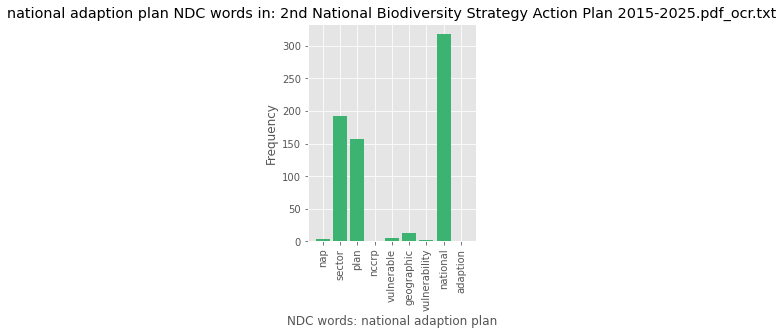

Graphing the occurences of climate change words in the document


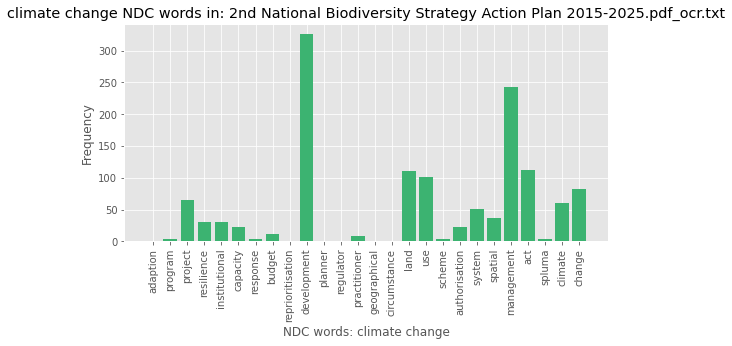

Graphing the occurences of early warning words in the document


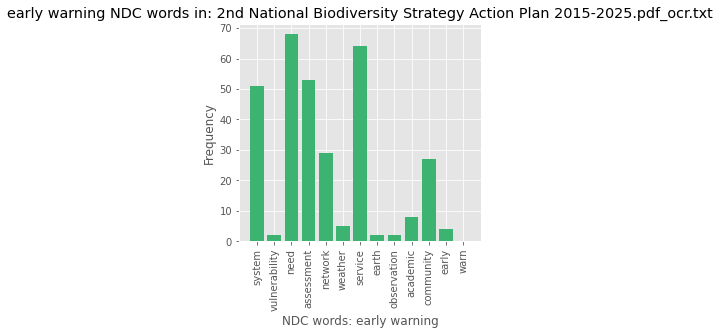

In [64]:
#just to test - need to modularise/make more reproducible and tailor output to be useful across documents
#could also link this back to the df of the documents to output a table with some summary metrics for keywords 
#in each document of interest
graphs_folder = '../../outputs/bar_charts/'    
    
for key in ndc_dict.keys(): 
    print("Graphing the occurences of %s words in the document" % key)
    topic_frequencies =  calculate_topic_frequency_subset(word_freq, ndc_dict, str(key))
    plot_word_freq_barchart_ndc(topic_frequencies, str(key), doc_name, graphs_folder) 

In [ ]:
ndc_climate_idxs = [ent.start for ent in doc.ents]
if key == 'climate change':
        print("Graphing the occurences of %s words in the document" % key)
        topic_frequencies = calculate_topic_frequency_subset(word_freq, ndc_dict, str(key))
        plot_word_freq_barchart_ndc(topic_frequencies, str(key), doc_name, graphs_folder) 

### Lets take a closer look at the climate change NDC keywords

In [56]:
#for key in ndc_dict.keys(): 
#    if key == 'climate change':
#        print("Graphing the occurences of %s words in the document" % key)
#        topic_frequencies = calculate_topic_frequency_subset(word_freq, ndc_dict, str(key))
#        plot_word_freq_barchart_ndc(topic_frequencies, str(key), doc_name, graphs_folder) 

### Where do these words appear in the document?

In [103]:
window_tokens_overall = make_window_text(tokens, max_length=25)

#### Use indexes from spacy matcher 

In [104]:
#may want to increase the min_distance/set it as a function of window size
window_size = 200
min_dist = 200
idx_for_window = filter_idx_for_overlap(idxs=climate_ndc_idxs_from_matcher, min_dist=min_dist)

[36, 72, 12, 44, 99, 261, 100, 20, 6, 21, 54, 20, 13, 68, 3, 10, 41, 96, 17, 17]
The number of times the idx words were found was:  356 
 The number of idx words seperated by at least the min_distance was :  35


In [105]:
count = 0
for index in idx_for_window[0:len(idx_for_window)]:
    count += 1
    print(index)
    window_tokens = return_window(index, window_tokens_overall, size=window_size)[2]
    window_text = ' '.join([token.text for token in window_tokens])
    #print(window_text)
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, window_text) #may want to keep this for the windows for a more granular analysis
    df_sdg_sorted = df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)
    #print(df_sdg_sorted.head())
    print(list(df_sdg_sorted[df_sdg_sorted['sdg_keywords_num'] > 0]['sdg_keywords'][:10])) #print top 10 positive valued keywords
    #print a summary of the SDG words found: 
    summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    if count == 1: 
        summary_sdg_df = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
    else: 
        summary_sdg_df_for_merge = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
        summary_sdg_df = summary_sdg_df.merge(summary_sdg_df_for_merge, left_index=True, right_index=True)

361
['environment', 'development', 'united nations', 'diversity', '$', 'fund', 'biodiversity']
2419
['diversity', 'development', 'indigenous', '$', 'work', 'biodiversity', 'workforce']
2792
['$']
3267
['$', 'targets', 'aichi targets', 'development']
3711
['biodiversity', 'diversity', '$', 'youth', 'activities', 'policy']
3989
['stem', 'diversity', 'policy', '$', 'biodiversity', 'biodiversity conservation']
4795
['$', 'targets', 'eu']
5026
['$', 'targets', 'stakeholders']
5868
['diversity', 'biodiversity', 'finance', 'hss', 'training', 'authority', 'finance', 'stem', '$', 'education']
7139
['environment', 'economic development', 'gdp', '$', 'tourism', 'economic development', 'development', 'gef', 'iucn']
7392
['environment', 'international relations', 'gdp', 'minerals', 'higher education', '$', 'education', 'gef', 'tourism', 'training']
7904
['environment', 'environmental management', 'water and sanitation', 'land', 'water', 'work', 'technology', 'stem', '$', 'trade']
9693
['diversity',

In [106]:
summary_sdg_df

,sdg_kw_361,sdg_kw_2419,sdg_kw_2792,sdg_kw_3267,sdg_kw_3711,sdg_kw_3989,sdg_kw_4795,sdg_kw_5026,sdg_kw_5868,sdg_kw_7139,...,sdg_kw_17531,sdg_kw_18030,sdg_kw_18783,sdg_kw_20190,sdg_kw_21093,sdg_kw_21343,sdg_kw_21724,sdg_kw_22436,sdg_kw_23338,sdg_kw_23853
sdg_topic,,,,,,,,,,,,,,,,,,,,,
SDG1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SDG10,2,1,0,1,0,0,0,0,1,1,...,1,0,1,3,0,0,0,1,1,1
SDG11,0,1,0,0,0,0,0,0,1,0,...,0,2,4,0,0,0,0,0,0,0
SDG12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SDG13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SDG14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SDG15,6,1,0,0,2,2,0,0,4,3,...,3,3,4,1,1,3,3,0,2,1
SDG16,2,0,0,0,1,1,0,1,1,3,...,0,1,0,2,1,0,0,0,0,0
SDG17,0,0,0,2,0,0,2,1,0,0,...,0,0,1,2,0,0,0,0,0,0


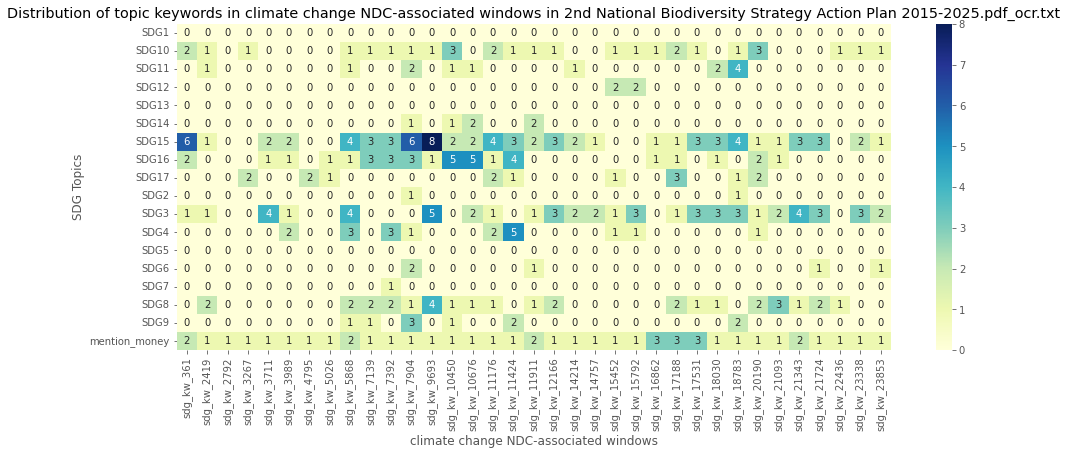

In [108]:
#make heatmap of plot above
plt.figure(figsize=(16, 6))
ax = sns.heatmap(summary_sdg_df,
                 annot=True, #fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("climate change NDC-associated windows")
plt.ylabel("SDG Topics")
title = ("Distribution of topic keywords in climate change NDC-associated windows in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across windows from spacy matching.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

In [112]:
index=361
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]
print("")

index=5868
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]
print("")

index=9693
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]
print("")

test_text = return_window(index, window_tokens_overall, size=window_size)[2]
test_text

final version july 2015 the 2015 national biodiversity strategy and action plan ( nbsap ) was developed for the department of environmental affairs by linkd environmental services and funded by the united nations development programme ( undp ) . alle : : environmental affairs py department : e environmental affairs republic of south africa department of environmental affairs united nations development

committee bhcds biodiversity human capital development strategy biofin biodiversity finance initiative bmp - e biodiversity management plans for ecosystems bmp - s biodiversity management plans for species botsoc botanical society of south africa cara conservation of agriculture resources act cathsseta culture , arts , tourism , hospitality , sports sector education training authority cbd convention

natural nationa ationa organisi association of conservancies of south africa action plan biodiversity assessment biodiversity and business network biodiversity economy strategy biodiversity 

natural nationa ationa organisi association of conservancies of south africa action plan biodiversity assessment biodiversity and business network biodiversity economy strategy biodiversity framework biodiversity strategy and action plan rimental finding development plan department of tourism environmental advisory forum environmental management act environmental skills planning forum implementing

### Using other resources:

### NDC Ontology with SDG classifications

In [92]:
sdg_ontology = pd.read_csv('../additional_resources/Ontology_final_modified.csv', sep=';')#, #skiprows=0)
SDG1_keywords = list(sdg_ontology[sdg_ontology['clasification']=='SDG1']['keyword'])
#print(SDG1_keywords)
sdg_ontology.head(20)
#print(list(ndc_ontology[ndc_ontology['clasification']=='SDG3']['keyword']))

,keyword,clasification
0,"""bop"" countries",SDG1
1,absolute poverty,SDG1
2,bellagio principles,SDG1
3,child nutritional status,SDG1
4,counting marginalised children,SDG1
5,dimensions of inequality,SDG1
6,diseases of poverty,SDG1
7,economic marginalisation,SDG1
8,education poverty,SDG1
9,educational poverty,SDG1


In [93]:
import re
document_text = ' '.join([token.text for token in window_tokens_overall])

def find_patterns_df(pattern_list, text, topic_name):
    pattern_locations = []
    pattern_num = []
    for pattern in pattern_list:
        #print(pattern)
        re.findall(pattern, text, flags=0)
        #pattern_locations = [(m.start(0), m.end(0)) for m in re.finditer(pattern, text)] #if want start and end
        locations = [m.start(0) for m in re.finditer(pattern, text)]
        pattern_locations.append(locations)
        pattern_num.append(int(len(locations)))
    #print(pattern_locations)
        #if len(pattern_locations) > 0: 
        #    print(pattern, len(pattern_locations), pattern_locations)
    return pd.DataFrame({'sdg_topic': topic_name,
                         'sdg_keywords': pattern_list,
                         'sdg_keywords_num': pattern_num,
                         'sdg_keyword_locations': pattern_locations})


#look at SDGs across document/at document level
sdg_list = ['SDG1', 'SDG2', 'SDG3', 'SDG4', 'SDG5', 'SDG6', 'SDG7', 'SDG8', 'SDG9', 
            'SDG10', 'SDG11', 'SDG12', 'SDG13', 'SDG14', 'SDG15', 'SDG16', 'SDG17', 
            "mention_money"]

def make_sdg_df(sdg_list, sdg_ontology, text):
    df_sdg = pd.DataFrame()
    for sdg in list(sdg_list):
        sdg_keywords = list(sdg_ontology[sdg_ontology['clasification']==sdg]['keyword'])
        #print(sdg)
        df_sdg_to_add = find_patterns_df(sdg_keywords, text, topic_name=sdg)
        df_sdg = pd.concat([df_sdg, df_sdg_to_add])
    return df_sdg

df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)

#lets see the 50 words that occur the most often
df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)[:50]

,sdg_topic,sdg_keywords,sdg_keywords_num,sdg_keyword_locations
288,SDG3,diversity,870,"[115, 207, 677, 1205, 1371, 1519, 1838, 2100, ..."
25,SDG15,biodiversity,841,"[112, 204, 674, 1202, 1368, 1516, 1835, 2097, ..."
20,SDG10,development,328,"[375, 555, 912, 1267, 1901, 2463, 3371, 5713, ..."
133,SDG4,stem,278,"[4087, 4142, 4199, 4257, 5430, 5820, 6325, 793..."
63,SDG15,environment,227,"[0, 35, 288, 319, 417, 457, 518, 583, 728, 622..."
179,SDG8,work,190,"[1576, 2512, 3514, 5231, 8019, 8202, 9109, 963..."
95,SDG15,land,190,"[6449, 7813, 8803, 8855, 8997, 9009, 10190, 11..."
45,SDG9,infrastructure,115,"[2015, 10218, 11448, 13122, 13604, 18923, 2088..."
160,SDG16,government,106,"[629, 1316, 8644, 10575, 16788, 19736, 29833, ..."
147,SDG15,protected area,100,"[4462, 9940, 18355, 24885, 28779, 36722, 38420..."


In [67]:
for i in range(): 
    print('Processing doc: ', doc_name)
    
document_text = ' '.join([token.text for token in window_tokens_overall])
df_sdg = make_sdg_df(sdg_list, sdg_ontology, document_text)
doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
doc_summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("%s"% doc_name)})

#if count == 1: 
#    summary_sdg_df = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
#else: 
#    summary_sdg_df_for_merge = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
#    summary_sdg_df = summary_sdg_df.merge(summary_sdg_df_for_merge, left_index=True, right_index=True)

,2nd National Biodiversity Strategy Action Plan 2015-2025.pdf_ocr.txt
sdg_topic,
SDG1,24
SDG10,359
SDG11,294
SDG12,70
SDG13,134
SDG14,241
SDG15,1608
SDG16,612
SDG17,220


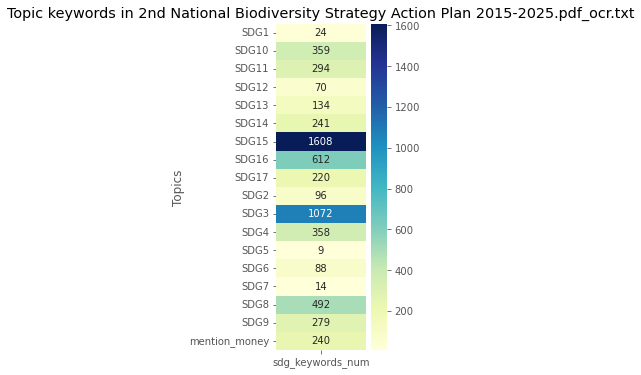

In [94]:
plot_folder = '../../outputs/heatmaps/'
#print a summary of the SDG words found: 
doc_summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
doc_summary_sdg.to_frame()
#doc_summary_sdg.to_frame()
plt.figure(figsize=(2, 6))
ax = sns.heatmap(doc_summary_sdg.to_frame(), 
                 annot=True, fmt="d", 
                 cmap="YlGnBu")

#plt.xlabel("climate change NDC-associated windows")
plt.ylabel("Topics")
title = ("Topic keywords in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across document v1.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

In [32]:
len(idx_for_window)
for index in idx_for_window[60:63]:
    print(return_window(index, window_tokens_overall)[2])
idx_for_window[60:63]

in terms 7 in 2005 the national department responsible for the environment included tourism and was known as the department of environmental affairs and tourism ( deat ) . this function has subsequently
, namely : the department of environmental affairs ( dea ) and the national department of tourism ( ndt ) . 10 of the biodiversity act and is a public entity , falling under the minister of environmental
on the state of biodiversity , and managing botanical gardens . south african national parks ( sanparks ) , which was established in terms of the protected areas act as a conservation authority mandated


[51933, 52172, 52742]

In [33]:
df_sdg_sorted  = df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)
list(df_sdg_sorted[df_sdg_sorted['sdg_keywords_num'] > 0]['sdg_keywords'][:10])

['diversity',
 'biodiversity',
 'development',
 'stem',
 'environment',
 'work',
 'land',
 'infrastructure',
 'government',
 'protected area']

In [34]:
count = 0
for index in idx_for_window[60:63]:
    count += 1
    print(index)
    window_tokens = return_window(index, window_tokens_overall, size=200)[2]
    window_text = ' '.join([token.text for token in window_tokens])
    print(window_text)
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, window_text)
    df_sdg_sorted = df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)
    #print(df_sdg_sorted.head())
    print(list(df_sdg_sorted[df_sdg_sorted['sdg_keywords_num'] > 0]['sdg_keywords'][:10])) #print top 10 positive valued keywords
    #print a summary of the SDG words found: 
    summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    if count == 1: 
        summary_sdg_df = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
    else: 
        summary_sdg_df_for_merge = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
        summary_sdg_df = summary_sdg_df.merge(summary_sdg_df_for_merge, left_index=True, right_index=True)

51933
for energy , amongst others . o south african national biodiversity institute ( sanbi ) was established in terms 7 in 2005 the national department responsible for the environment included tourism and was known as the department of environmental affairs and tourism ( deat ) . this function has subsequently been split into two departments , namely : the department of environmental affairs ( dea
['environment', 'tourism', 'energy', '$', 'biodiversity', 'diversity']
52172
affairs and tourism ( deat ) . this function has subsequently been split into two departments , namely : the department of environmental affairs ( dea ) and the national department of tourism ( ndt ) . 10 of the biodiversity act and is a public entity , falling under the minister of environmental affairs , with the purpose of assisting in achieving the objectives of the biodiversity act
['diversity', 'environment', 'tourism', 'biodiversity', '$']
52742
, provision of knowledge and information , policy support and ad

In [35]:
#may want to increase the min_distance/set it as a function of window size
window_size = 200
min_dist = 200
idx_for_window = filter_idx_for_overlap(idxs=ndc_climate_idxs, min_dist=min_dist)

[1009, 133, 500, 51, 163, 41, 2113, 8900, 133, 242, 79, 99, 127, 204, 112, 269, 51, 160, 41, 1241]
The number of times the idx words were found was:  869 
 The number of idx words seperated by at least the min_distance was :  371


In [36]:
count = 0
for index in idx_for_window[0:len(idx_for_window)]:
    count += 1
    print(index)
    window_tokens = return_window(index, window_tokens_overall, size=window_size)[2]
    window_text = ' '.join([token.text for token in window_tokens])
    #print(window_text)
    df_sdg = make_sdg_df(sdg_list, sdg_ontology, window_text) #may want to keep this for the windows for a more granular analysis
    df_sdg_sorted = df_sdg.sort_values(by=['sdg_keywords_num'], ascending=False)
    #print(df_sdg_sorted.head())
    print(list(df_sdg_sorted[df_sdg_sorted['sdg_keywords_num'] > 0]['sdg_keywords'][:10])) #print top 10 positive valued keywords
    #print a summary of the SDG words found: 
    summary_sdg = df_sdg.groupby('sdg_topic')['sdg_keywords_num'].sum()
    if count == 1: 
        summary_sdg_df = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
    else: 
        summary_sdg_df_for_merge = summary_sdg.to_frame().rename(columns={"sdg_keywords_num": ("sdg_kw_%d"% index)})
        summary_sdg_df = summary_sdg_df.merge(summary_sdg_df_for_merge, left_index=True, right_index=True)

1637
['diversity', 'biodiversity', '$', 'work']
2779
['$', 'indigenous']
3534
['diversity', 'biodiversity', 'development', '$', 'youth', 'work']
5647
['diversity', 'biodiversity', 'finance', 'finance', '$', 'demography', 'stem', 'development']
14680
['diversity', 'activities', 'biodiversity', '$']
15227
['targets', '$', 'development', 'organization']
15543
['natural resources', 'human wellbeing', 'targets', 'stem', '$', 'health', 'development', 'wellbeing', 'natural resource']
16064
['development', 'equity', 'basic needs', 'stem', '$']
17305
['development', 'cost', 'fund', '$', 'eu', 'united nations', 'biodiversity', 'europe', 'diversity', 'european union']
18434
['conservation areas', 'development', '$', 'protected area', 'stem', 'protected areas', 'job creation', 'biodiversity', 'work', 'diversity']
18863
['activities', 'land', 'agenda', 'rural development', 'stem', 'rural', '$', 'infrastructure', 'ecological infrastructure', 'biodiversity']
19656
['diversity', 'biodiversity', '$', '

['fund', 'development', 'environment', 'eu', '$', 'iucn', 'development cooperation', 'funders']
70251
['development', 'environment', 'growth', 'biodiversity', 'agenda', '$', 'economic growth', 'development agenda', 'diversity']
70537
['natural resources', 'development', 'tourism', 'natural resource', '$', 'environment', 'rural', 'infrastructure', 'biodiversity', 'rural development']
70964
['infrastructure', 'diversity', 'development', 'biodiversity', '$']
71408
['infrastructure', 'water', 'biodiversity', 'diversity', 'ecological infrastructure', '$', 'health', 'stem']
72316
['economy', 'green economy', 'ecological infrastructure', 'diversity', '$', 'infrastructure', 'government', 'biodiversity', 'development']
72837
['ocean', 'economy', 'growth', 'governance', 'economic growth', '$', 'marine', 'unemployment', 'poverty', 'biodiversity']
73040
['biodiversity', 'diversity', 'economy', 'ocean', 'growth', 'governance', '$', 'marine', 'government', 'policies']
73647
['development', 'unesco',

['conservation areas', 'rent', 'protected area', '$', 'development', 'protected areas', 'conservation area']
114345
['protected area', 'protected areas', 'rent', 'conservation area', 'habitat', 'habitat loss', 'stem', '$', 'work', 'conservation areas']
115364
['ngos', 'biodiversity', 'law', 'conservation area', 'diversity', 'work', 'authority', '$', 'land']
116206
['ngos', 'economic benefits', 'biodiversity', 'protected area', '$', 'climate', 'protected areas', 'diversity']
116708
['government', 'peace', 'provincial government', 'protected area', 'protected areas', '$']
117815
['food', 'crop', '$', 'habitat loss', 'birds', 'tourism', 'habitat', 'ecotourism']
118842
['diversity', 'biodiversity', 'development', '$', 'fund', 'funding']
119948
['trade', 'authority', 'breeding', '$']
120366
['trade', 'climate change', 'habitat', 'rent', 'climate', 'breeding', '$']
121018
['work', 'stakeholders', '$', 'fund', 'funding', 'protected species']
121449
['diversity', 'ngos', 'activities', 'fund', 

['budget', 'government', 'donors', 'budgeting', 'financial', 'ngos', 'budgeting', '$', 'municipalities', 'donor']
165863
['diversity', 'biodiversity', 'finance', 'finance', 'water', 'natural resource', 'municipalities', '$']
166174
['diversity', '$', 'tax', 'biodiversity', 'farmers']
166837
['biodiversity', 'diversity', 'policies', '$', 'development', 'policy', 'budget']
167378
['diversity', 'policy', 'biodiversity', 'environment', '$', 'development', 'policies and legislation', 'policies']
167940
['diversity', 'biodiversity', 'policy', '$']
168190
['activities', '$', 'rent', 'marine']
169471
['energy', 'biodiversity', '$', 'degradation', 'environment', 'land', 'policy', 'land degradation', 'development', 'organisation']
169890
['diversity', 'stem', '$', 'activities', 'biodiversity']
171291
['society', 'waste management', 'land', 'natural resource', 'natural resources', 'climate', 'degradation', 'land degradation', 'policy', 'renewable energy']
172322
['diversity', 'biodiversity', 'inf

['education', 'fund', 'environment', 'teacher education', 'partnership', 'labor', 'learning', 'organisation', '$']
226023
['biodiversity', 'economy', '$', 'development', 'environment', 'green economy', 'partnership', 'diversity', 'work']
226382
['environment', 'development', 'global change', 'work', 'diversity', '$', 'technologies', 'biodiversity']
226749
['diversity', 'development', 'biodiversity', '$', 'work', 'who']
227198
['global change', 'fund', 'economy', 'technology', '$', 'integration', 'biodiversity', 'society', 'diversity']
227975
['targets', 'ocean', 'distribution', '$', 'tax', 'biodiversity', 'aichi targets', 'diversity']
228871
['biodiversity', 'diversity', 'government', '$', 'stem', 'development', 'partnership', 'stakeholders']
229943
['organizations', 'government', 'organization', 'communities', '$', 'indigenous', 'work']
230797
['partnerships', 'partnership', 'institutions', 'equity', '$']
231532
['natural resource', 'environment', 'distribution', 'natural resources', 

In [37]:
summary_sdg_df

,sdg_kw_1637,sdg_kw_2779,sdg_kw_3534,sdg_kw_5647,sdg_kw_14680,sdg_kw_15227,sdg_kw_15543,sdg_kw_16064,sdg_kw_17305,sdg_kw_18434,...,sdg_kw_254548,sdg_kw_255014,sdg_kw_255249,sdg_kw_257211,sdg_kw_257799,sdg_kw_258306,sdg_kw_268696,sdg_kw_269995,sdg_kw_270522,sdg_kw_270836
sdg_topic,,,,,,,,,,,,,,,,,,,,,
SDG1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SDG10,0,0,1,1,0,1,1,3,2,1,...,0,0,1,3,0,0,0,1,0,0
SDG11,0,1,0,1,0,0,0,0,0,0,...,0,2,3,0,1,0,0,0,0,0
SDG12,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SDG13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SDG14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
SDG15,2,0,3,4,1,0,0,0,1,3,...,2,4,0,1,1,0,0,5,4,4
SDG16,0,0,0,0,0,0,0,1,1,2,...,2,0,0,1,0,1,0,0,0,0
SDG17,0,0,0,0,0,3,1,0,3,0,...,0,1,0,4,1,0,0,0,0,0


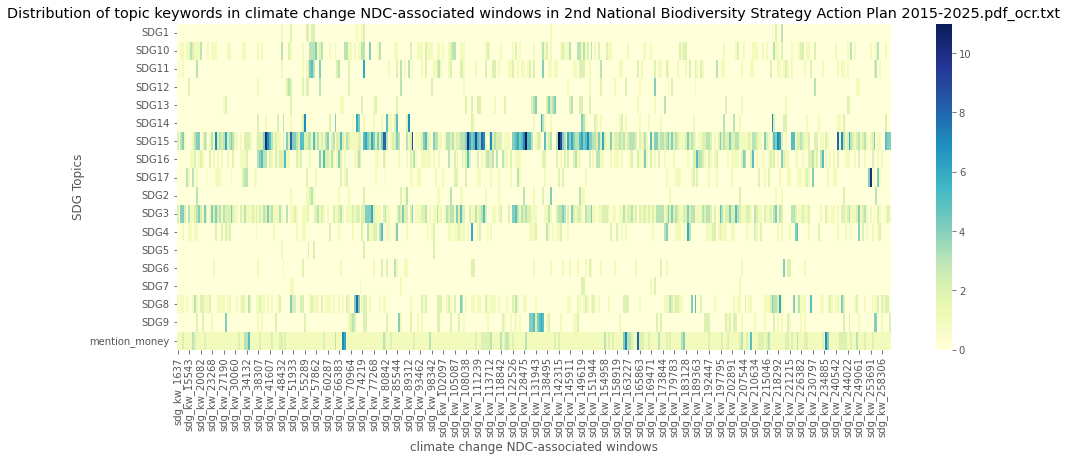

In [38]:
summary_sdg_df

#make heatmap of plot above
plt.figure(figsize=(16, 6))
ax = sns.heatmap(summary_sdg_df,
                 #annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("climate change NDC-associated windows")
plt.ylabel("SDG Topics")
title = ("Distribution of topic keywords in climate change NDC-associated windows in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across all windows v1.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

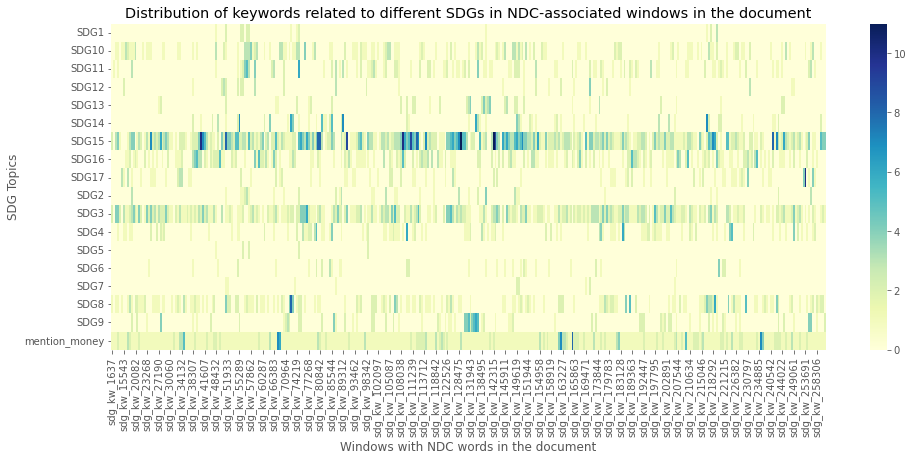

In [39]:
#make heatmap of plot above
plt.figure(figsize=(16, 6))
ax = sns.heatmap(summary_sdg_df,
                 #annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("Windows with NDC words in the document")
plt.ylabel("SDG Topics")
title = ("Distribution of keywords related to different SDGs in NDC-associated windows in the document")
plt.title(title)
plt.show()

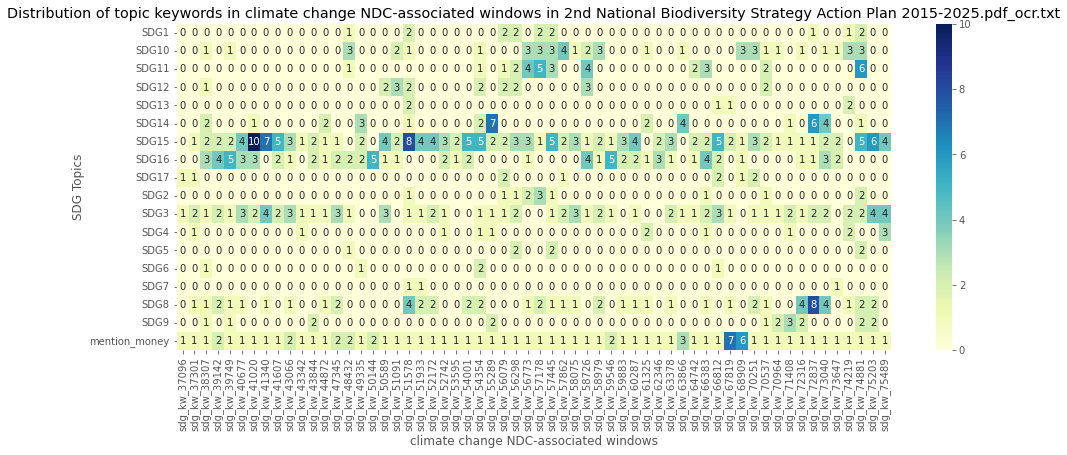

In [40]:
#make heatmap of plot above
plt.figure(figsize=(16, 6))
ax = sns.heatmap(summary_sdg_df.iloc[:, 40:100], #can show all windows with summary_sdg_df
                 annot=True, fmt="d", 
                 cmap="YlGnBu")
plt.xlabel("climate change NDC-associated windows")
plt.ylabel("SDG Topics")
title = ("Distribution of topic keywords in climate change NDC-associated windows in %s" % (doc_name))
plt.title(title)
file_name=(title + (' across windows 40-100 v1.png'))
plt.savefig((plot_folder+file_name), dpi=300, bbox_inches='tight')
plt.show()

### Lets see some examples: 
#### SDG15: "Protect, restore and promote sustainable use of terrestrial ecosystems, sustainably manage forests, combat desertification, and halt and reverse land degradation and halt biodiversity loss"
https://sdgs.un.org/goals/goal15

In [41]:
index=41020
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]
print("")
index=41340
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]

environmental management act ( act 107 of 1998 ) e national environmental management : biodiversity act ( act 10 of 2004 ) ( hereafter referred to as the biodiversity act ) e national environmental management : protected areas act ( act 57 of 2003 ) ( hereafter referred to as the protected areas act ) e marine living resources act ( act 18 of 1998 ) e national forest act ( act 84 of 1998 ) e provincial

resources act ( act 18 of 1998 ) e national forest act ( act 84 of 1998 ) e provincial biodiversity legislation — this differs from province to province e national biodiversity strategy and action plan ( 2005 ) e national biodiversity framework ( 2008 ) e national protected area expansion strategy ( 2008 ) e provincial biodiversity strategies , and provincial protected area expansion strategies


sdg_topic
SDG1             0
SDG10            0
SDG11            0
SDG12            0
SDG13            0
SDG14            0
SDG15            7
SDG16            0
SDG17            0
SDG2             0
SDG3             4
SDG4             0
SDG5             0
SDG6             0
SDG7             0
SDG8             1
SDG9             0
mention_money    1
Name: sdg_kw_41340, dtype: int64

#### SDG14: "Conserve and sustainably use the oceans, seas and marine resources for sustainable development"
https://sdgs.un.org/goals/goal14

In [42]:
index=55289
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]

to the draft water pricing strategy also recognise he importance of healthy freshwater ecosystems to water security through he inclusion of the use of revenue gained from water tariffs to support investment into ecological infrastructure for water security . department of agriculture , forestry and fisheries ( daff ) , which draws its egislative mandate from section 27(1)(b ) of the constitution of


sdg_topic
SDG1             0
SDG10            0
SDG11            0
SDG12            0
SDG13            0
SDG14            7
SDG15            2
SDG16            0
SDG17            0
SDG2             0
SDG3             1
SDG4             1
SDG5             0
SDG6             0
SDG7             0
SDG8             0
SDG9             2
mention_money    1
Name: sdg_kw_55289, dtype: int64

#### SDG08: "Promote sustained, inclusive and sustainable economic growth, full and productive employment and decent work for all"

In [43]:
index=72837
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]

helps to address poverty and unemployment . operation phakisa is initially implemented in two sectors , the ocean economy and health , and will be rolled out in other sectors . in the oceans economy four priority areas for unlocking the oceans economy through inclusive economic growth have been identified , one of which is marine protection services and ocean governance . other biodiversity and


sdg_topic
SDG1             1
SDG10            0
SDG11            0
SDG12            0
SDG13            0
SDG14            6
SDG15            1
SDG16            1
SDG17            0
SDG2             0
SDG3             2
SDG4             0
SDG5             0
SDG6             0
SDG7             0
SDG8             8
SDG9             0
mention_money    1
Name: sdg_kw_72837, dtype: int64

#### SDG11: "Make cities and human settlements inclusive, safe, resilient and sustainable"

In [44]:
index=74881
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]

poverty alleviation . examples include the working for water , working for wetlands , landcare and integrated sustainable rural development programmes . these present important opportunities to mainstream biodiversity considerations into development planning , capacity building and community empowerment . they also highlight the tremendous potential that investing in biodiversity and ecological infrastructure


sdg_topic
SDG1             2
SDG10            3
SDG11            6
SDG12            0
SDG13            0
SDG14            1
SDG15            5
SDG16            0
SDG17            0
SDG2             2
SDG3             2
SDG4             0
SDG5             2
SDG6             0
SDG7             0
SDG8             2
SDG9             2
mention_money    1
Name: sdg_kw_74881, dtype: int64

In [45]:
index=241379
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]

, long- supported through provincial biodiversity stewardship programmes resilience and ensure benefits to society vy the network of protected areas and areas protected under the protected areas act by 2028 , in protected areas : 10.8 m land - based npaes conservation areas includes a ( ha , km , km2 ) hectares , 353 km inshore , 210 000km2 marine representative sample of ecosystems and offshore


sdg_topic
SDG1             0
SDG10            0
SDG11            1
SDG12            0
SDG13            0
SDG14            1
SDG15            8
SDG16            2
SDG17            0
SDG2             0
SDG3             1
SDG4             1
SDG5             0
SDG6             0
SDG7             0
SDG8             1
SDG9             0
mention_money    1
Name: sdg_kw_241379, dtype: int64

In [46]:
index=67819
print(return_window(index, window_tokens_overall, size=window_size)[2]) #print(window_tokens[2])
summary_sdg_df[('sdg_kw_%d' % index)]

. for instance , for entities such as sanbi , sanparks and isimangaliso wetland park , these additional transfers amount to over r1.9 billion that is additional to the ro.5 billion allocated from the line department . in addition to public sector finance , the biodiversity sector has received substantial investment through various donors and donor - funded projects , programmes or funds , such


sdg_topic
SDG1             0
SDG10            0
SDG11            0
SDG12            0
SDG13            1
SDG14            0
SDG15            2
SDG16            0
SDG17            0
SDG2             0
SDG3             1
SDG4             0
SDG5             0
SDG6             0
SDG7             0
SDG8             1
SDG9             0
mention_money    7
Name: sdg_kw_67819, dtype: int64

### Parts of speech tagging

In [47]:
for token in filtered_tokens[:50]:
    print(token, token.tag_, token.pos_, spacy.explain(token.tag_))
print('\n')
    
nouns = []
adjectives = []
for token in filtered_tokens:
    if token.pos_ == 'NOUN':
        nouns.append(token)
    if token.pos_ == 'ADJ':
        adjectives.append(token)

print('some nouns spacy called in the document include:', '\n', nouns[:50], '\n')
print('some adjectives spacy called in the document include:', '\n', adjectives[:50])

environmental JJ ADJ adjective (English), other noun-modifier (Chinese)
affair NN NOUN noun, singular or mass
department NNP PROPN noun, proper singular
environmental NNP PROPN noun, proper singular
affairs NNPS PROPN noun, proper plural
republic NNP PROPN noun, proper singular
south NNP PROPN noun, proper singular
africa NNP PROPN noun, proper singular
y NNP PROPN noun, proper singular
south NNP PROPN noun, proper singular
africa NNP PROPN noun, proper singular
24 CD NUM cardinal number
national JJ ADJ adjective (English), other noun-modifier (Chinese)
biodiversity NN NOUN noun, singular or mass
strategy NN NOUN noun, singular or mass
action NN NOUN noun, singular or mass
plan NN NOUN noun, singular or mass
2015 CD NUM cardinal number
2025 CD NUM cardinal number
final JJ ADJ adjective (English), other noun-modifier (Chinese)
version NN NOUN noun, singular or mass
july NNP PROPN noun, proper singular
2015 CD NUM cardinal number
2015 CD NUM cardinal number
national JJ ADJ adjective (Eng

### Entity recognition

In [ ]:
#can display entity property for the tokens as well: 
entities=[(i, i.label_, i.label) for i in filtered_tokens[1400:1700].ents]
print(entities[:10])

token_subset = tokens[100:500]
displacy.render(token_subset, style = "ent", jupyter = True) #use original tokens

### Dependency visualization in sentences

In [ ]:
sent_example = nlp("For example, it is estimated that between 9 and 12 million DATE people in impoverished rural areas directly use natural resources such as fuel wood, wild fruits and wooden utensils as a source of energy, food and building material respectively (Shackleton ORG 2004)")
sentence_spans = list(sentences)
sentence_spans[:10]
displacy.render(sentence_spans[80], style="dep", jupyter= True)

## Sandbox (extra code to be deleted if not of use)

In [ ]:
'''
a_string = "one two three"
word_list = a_string.split()
number_of_words = len(word_list)
print(number_of_words)
pattern = "ecological"
window_tokens
print([(token.text, token.idx) for token in window_tokens if token.text == "such"][:])
print([(token.text, token.idx) for token in window_tokens if token.text == "as"][:])
#token.idx==

#find first word
patterns = ["ecological", "such as"]
pattern = ["ecological"]
window_tokens

for pattern in patterns:
    for token in window_tokens: 
        if token.text == pattern:
            print(token.idx)
#check if subsequent word matches

def match_words_return_idx(token_list, pattern_list):
    for pattern in pattern_list:
        pattern_idxs = []
        word_list = pattern.split()
        number_of_words = len(word_list)
        if number_of_words == 1: 
            #return list of matches to the single word (pattern)
            pattern_idxs = [token.idx for token in window_tokens if token.text == pattern]
            print(pattern, pattern_idxs)
        if number_of_words > 1: 
            #return list of matches to the first word in the pattern
            pattern_idxs = [token.idx for token in window_tokens if token.text == word_list[0]] 
            print(pattern, pattern_idxs) #print these matches
            #check the following token to see if it matches the next word 
            for idx in pattern_idxs:
                #print([token.text for token in window_tokens if token.idx==(idx+1)])
            print(pattern)
        
        
match_words_return_idx(window_tokens, patterns)
list(pattern)
'''

In [ ]:
'''
#lets make a histogram of these to see where most of them fall in the document: 
## Plot distribution of where NDC words fall in the document
print(len(ndc_climate_idxs))
plt.rcParams["figure.figsize"] = (20,4)
plt.hist(x=ndc_climate_idxs, bins=200)
plt.hist(x=idx_for_window, bins=200)
#plt.hist(x=ndc_early_warning_idxs, bins=(round(len(ndc_early_warning_idxs))))
plt.xlabel("Location of NDC words in the document")
plt.ylabel("Frequency")
title = ("Distribution of NDC word locations in the document")
plt.title(title)
plt.show()

ax = sns.displot(x=ndc_climate_idxs, kind="kde", bw_adjust=0.1)
ax = sns.displot(x=ndc_early_warning_idxs, kind="kde", bw_adjust=0.1)
plt.xlabel("Location of NDC words in the document")
plt.ylabel("Frequency")
title = ("Distribution of NDC word locations in the document")
plt.title(title)
plt.show()

plt.rcParams["figure.figsize"] = (20,4)
sns.displot(x=ndc_climate_idxs, kde=True, bins=100)
'''

'''
#window_starts = []
#window_ends = []
#for index in idx_for_window: #ndc_climate_idxs:
    #lower_limit = return_window(index, tokens)[0]
    #upper_limit = return_window(index, tokens)[1]
    #window_starts.append(lower_limit)
    #window_ends.append(upper_limit)
    #print(lower_limit, upper_limit)

#for index in ndc_climate_idxs[:10]:
#    return_window(index, tokens)
for index in idx_for_window[5:10]:#ndc_climate_idxs[30:40]:
    window_tokens = return_window(index, window_tokens_overall, size=100)
    print(window_tokens[2])
'''